In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz

!pip install findspark
!pip install pyspark py4j

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .getOrCreate()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql.functions import to_date
from  pyspark.sql.functions import col
from pyspark.sql.functions import unix_timestamp
data=spark.read.csv('/content/drive/MyDrive/Research/PM25_MODISDrive_temp.csv', header=True, nullValue='NA')
data = data.withColumn("date", to_date("date", "dd/MM/yyyy"))
# assuming the dataframe has a column named "date_col" of type "date"
data = data.withColumn("date", unix_timestamp("date"))
data.show(5)

data = data.dropna("any")
data = data.drop('SATELLITE','Temperature','dist','modis_green','modis_blue','Humidity','Temp')
data = data.filter((col("PM2_5")) != "#N/A")  # Replace "column_name" with the actual column name
data.show()
data.printSchema()

+---------+----------+--------------------+----------+----------+-----------+--------+-------+-------+-----------+
|SATELLITE|      date|                name|      dist|modis_blue|modis_green|Humidity|   Temp|  PM2_5|Temperature|
+---------+----------+--------------------+----------+----------+-----------+--------+-------+-------+-----------+
|        T|1577836800|          Quoc Huong|         2|       103|         71| 45.4625|31.3075|  21.72|      32.87|
|        T|1577836800|         Do Xuan Hop|         9|        93|         64|   34.41|22.3525| 37.485|      33.81|
|        T|1578009600|   Xo Viet Nghe Tinh|Binh Thanh|       247|        171| 31.6025|48.5725|  26.63|      36.85|
|        T|1578009600|         Nguyen Kiem|    Go Vap|       217|        150|  46.435|  32.51|36.3075|      38.55|
|        T|1578009600|Truong THCS Nguye...|    Go Vap|       237|        164|    42.8|  27.59| 33.675|      37.59|
+---------+----------+--------------------+----------+----------+-----------+---

In [ ]:
data = data.withColumn("PM2_5",data["PM2_5"].cast('double'))
data = data.withColumn("date",data["date"].cast('double'))

In [ ]:
VNU = data.filter(data.name == "VNUHCM - 225 Nguyen Van Cu")
tan_thuan_dong = data.filter(data.name == "Tan Thuan Dong")
tran_phu = data.filter(data.name == "Tran Phu")
nguyen_cong_tru = data.filter(data.name == "Nguyen Cong Tru")
nguyen_cong_hoan = data.filter(data.name == "Nguyen Cong Hoan")
nguyen_kiem = data.filter(data.name == "Nguyen Kiem")
do_xuan_hop = data.filter(data.name == "Do Xuan Hop")
quoc_huong = data.filter(data.name == "Quoc Huong")
au_co = data.filter(data.name == "Au Co")
bui_xuan_phai = data.filter(data.name == "Bui Xuan Phai")
cao_lo = data.filter(data.name == "Cao Lo")
co_so_bao_tro_xa_hoi_thao_dan = data.filter(data.name == "Co So Bao Tro Xa Hoi Thao Dan")
duong_so_1 = data.filter(data.name == "Duong so 1")
hoc_lac = data.filter(data.name == "Hoc Lac")
linh_chieu = data.filter(data.name == "Linh Chieu")
luong_truc_dam = data.filter(data.name == "Luong Truc Dam")
ngyuen_khoai = data.filter(data.name == "Nguyen Khoai")
phu_my_hung = data.filter(data.name == "Phu My Hung")
tan_quy = data.filter(data.name == "Tan Quy")
tan_quy_dong = data.filter(data.name == "Tan Quy Dong")
thao_dien = data.filter(data.name == "Thao Dien")
truong_thcs_le_quy_don = data.filter(data.name == "Truong THCS Le Quy Don")
truong_thcs_nguyen_van_nghi = data.filter(data.name == "Truong THCS Nguyen Van Nghi")
vinh_loc_b = data.filter(data.name == "Vinh Loc B")
xo_viet_nghe_tinh = data.filter(data.name == "Xo Viet Nghe Tinh")

data_list = [VNU, tan_thuan_dong, tran_phu, nguyen_cong_tru, nguyen_cong_hoan, nguyen_kiem, do_xuan_hop, quoc_huong, au_co, bui_xuan_phai,
             cao_lo, co_so_bao_tro_xa_hoi_thao_dan, duong_so_1, hoc_lac, linh_chieu, luong_truc_dam, ngyuen_khoai, phu_my_hung, tan_quy,
             tan_quy_dong, thao_dien, truong_thcs_le_quy_don, truong_thcs_nguyen_van_nghi, vinh_loc_b, xo_viet_nghe_tinh]


Silhouette Score: 0.7067239643114713
Silhouette Score: 0.006955086839752496
Silhouette Score: 0.031516045701594775
Silhouette Score: 0.7814151489664056
Silhouette Score: 0.6563480402394244
Silhouette Score: 0.627089779280389
Silhouette Score: 0.6347400757352261
Silhouette Score: 0.7681788728828018


Text(0, 0.5, 'PM_2.5')

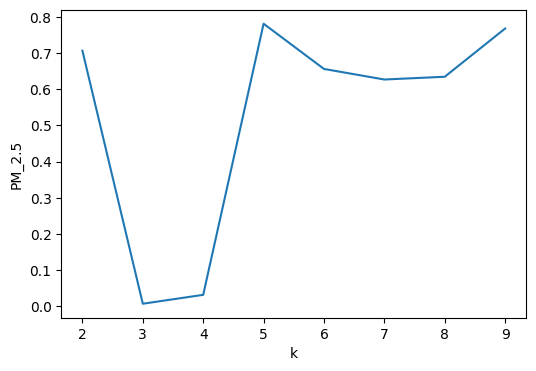

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler

if "features" in data.columns:
    data = data.drop("features")

# Select the date and PM2_5 columns
selected_columns = ["date","PM2_5"]

# Convert selected columns to vector format
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
data = assembler.transform(data)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale = scale.fit(data)
data_scale_output = data_scale.transform(data)

# Determine the optimal number of clusters using silhouette analysis
silhouette_scores = []
evaluator = ClusteringEvaluator(featuresCol='standardized', metricName='silhouette')
for K in range(2,10):
  BKMeans_= BisectingKMeans(featuresCol='standardized', k=K, minDivisibleClusterSize =1)
  BKMeans_fit = BKMeans_.fit(data_scale_output)
  BKMeans_transform = BKMeans_fit.transform(data_scale_output)
  evaluation_score = evaluator.evaluate(BKMeans_transform)
  silhouette_scores.append(evaluation_score)
  print("Silhouette Score:",evaluation_score)

#Visualizing the silhouette scores in a plot

fig, ax = plt.subplots(1,1, figsize =(6,4))
ax.plot(range(2,10),silhouette_scores)
ax.set_xlabel('k')
ax.set_ylabel('PM_2.5')

In [ ]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
model = pca.fit(data_scale_output)
trans_df = model.transform(data_scale_output)
trans_df.show(5)

+-----------+--------------------+-------+--------------------+--------------------+--------------------+
|       date|                name|  PM2_5|            features|        standardized|        pca_features|
+-----------+--------------------+-------+--------------------+--------------------+--------------------+
|1.5778368E9|          Quoc Huong|  21.72| [1.5778368E9,21.72]|[172.449195798636...|[-1.5778367999977...|
|1.5778368E9|         Do Xuan Hop| 37.485|[1.5778368E9,37.485]|[172.449195798636...|[-1.5778367999976...|
|1.5780096E9|   Xo Viet Nghe Tinh|  26.63| [1.5780096E9,26.63]|[172.468081922368...|[-1.5780095999976...|
|1.5780096E9|         Nguyen Kiem|36.3075|[1.5780096E9,36.3...|[172.468081922368...|[-1.5780095999976...|
|1.5780096E9|Truong THCS Nguye...| 33.675|[1.5780096E9,33.675]|[172.468081922368...|[-1.5780095999976...|
+-----------+--------------------+-------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# standardize the data to bring them to a comparable scale

scale=StandardScaler(inputCol='pca_features',outputCol='pca_standardized')
data_scale_pca=scale.fit(trans_df)
data_scale_pca_output=data_scale_pca.transform(trans_df)
data_scale_pca_output.show(5)

+-----------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+
|       date|                name|  PM2_5|            features|        standardized|        pca_features|    pca_standardized|
+-----------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+
|1.5778368E9|          Quoc Huong|  21.72| [1.5778368E9,21.72]|[172.449195798636...|[-1.5778367999977...|[-172.44919579815...|
|1.5778368E9|         Do Xuan Hop| 37.485|[1.5778368E9,37.485]|[172.449195798636...|[-1.5778367999976...|[-172.44919579815...|
|1.5780096E9|   Xo Viet Nghe Tinh|  26.63| [1.5780096E9,26.63]|[172.468081922368...|[-1.5780095999976...|[-172.46808192188...|
|1.5780096E9|         Nguyen Kiem|36.3075|[1.5780096E9,36.3...|[172.468081922368...|[-1.5780095999976...|[-172.46808192188...|
|1.5780096E9|Truong THCS Nguye...| 33.675|[1.5780096E9,33.675]|[172.468081922368...|[-1.5780095999976...|[-172.

Silhouette Score: 0.7598100929167868
Silhouette Score: 0.549217571888315
Silhouette Score: 0.7465019858509288
Silhouette Score: 0.6645653679341689
Silhouette Score: 0.727243597053994
Silhouette Score: 0.7897868373869985
Silhouette Score: 0.789069404164082
Silhouette Score: 0.6933627056983838


Text(0, 0.5, 'PM_2.5')

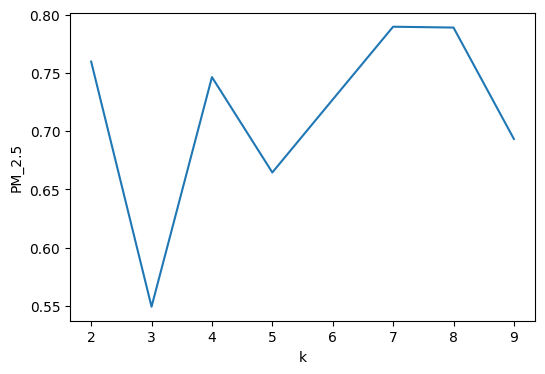

In [ ]:
silhouette_score_pca = []
evaluator_pca = ClusteringEvaluator(predictionCol='prediction', featuresCol='pca_standardized', metricName='silhouette', distanceMeasure='squaredEuclidean')
for K in range(2,10):
  KMeans_algo_pca = BisectingKMeans(featuresCol='pca_standardized', k=K, minDivisibleClusterSize =1)
  KMeans_fit_pca = KMeans_algo_pca.fit(data_scale_pca_output)
  output_pca = KMeans_fit_pca.transform(data_scale_pca_output)
  score_pca = evaluator.evaluate(output_pca)
  silhouette_score_pca.append(score_pca)
  print("Silhouette Score:",score_pca)

#Visualizing the silhouette scores in a plot
fig, ax = plt.subplots(1,1, figsize =(6,4))
ax.plot(range(2,10),silhouette_score_pca)
ax.set_xlabel('k')
ax.set_ylabel('PM_2.5')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


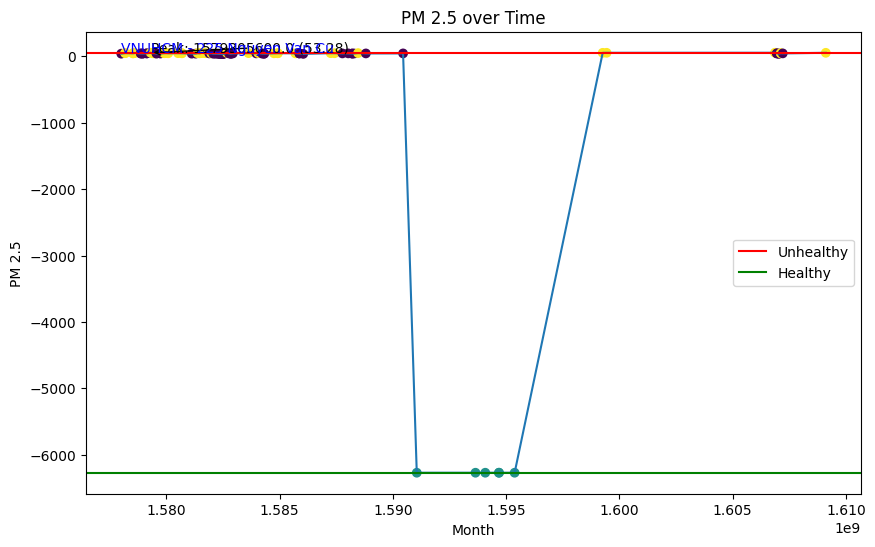

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


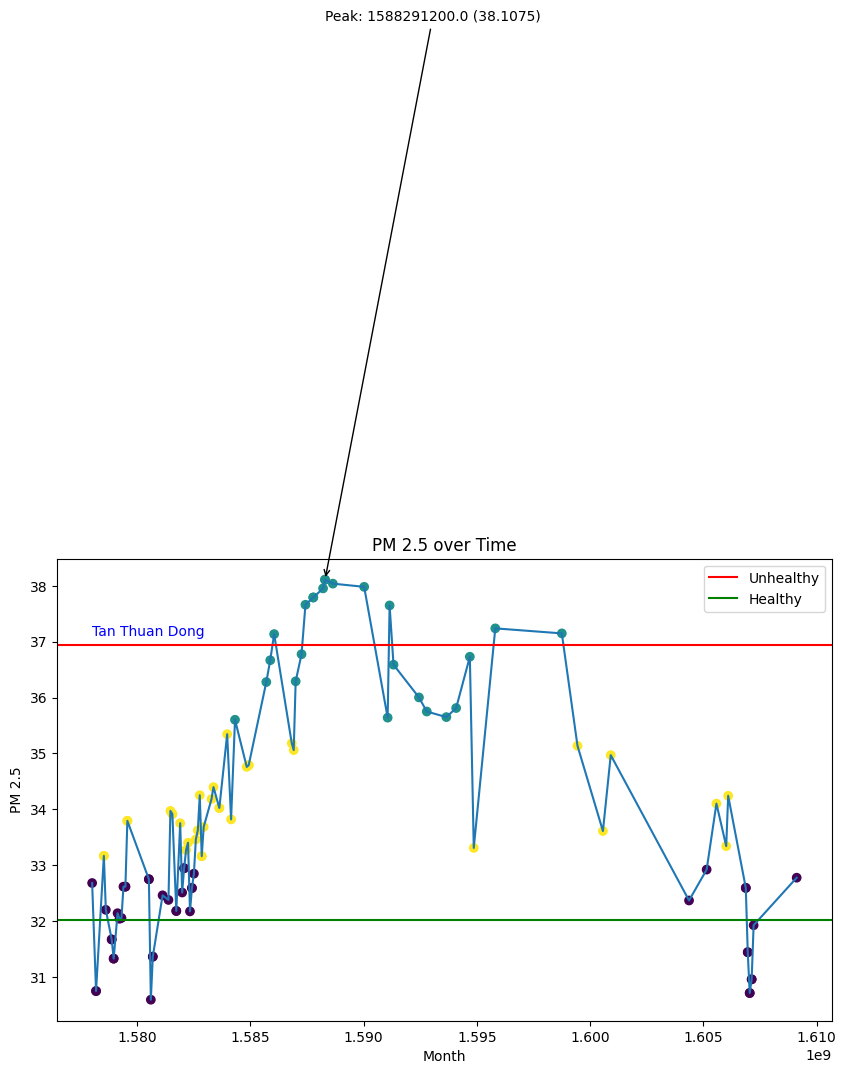

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


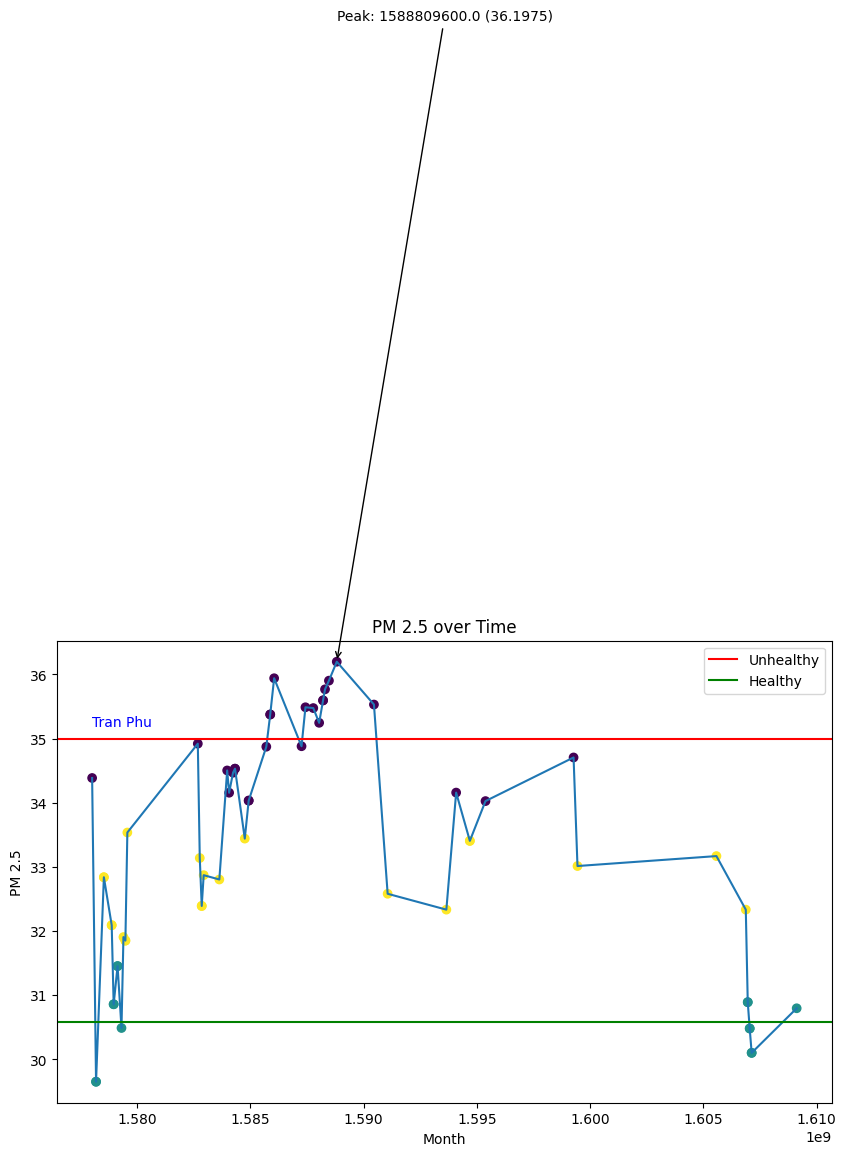

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


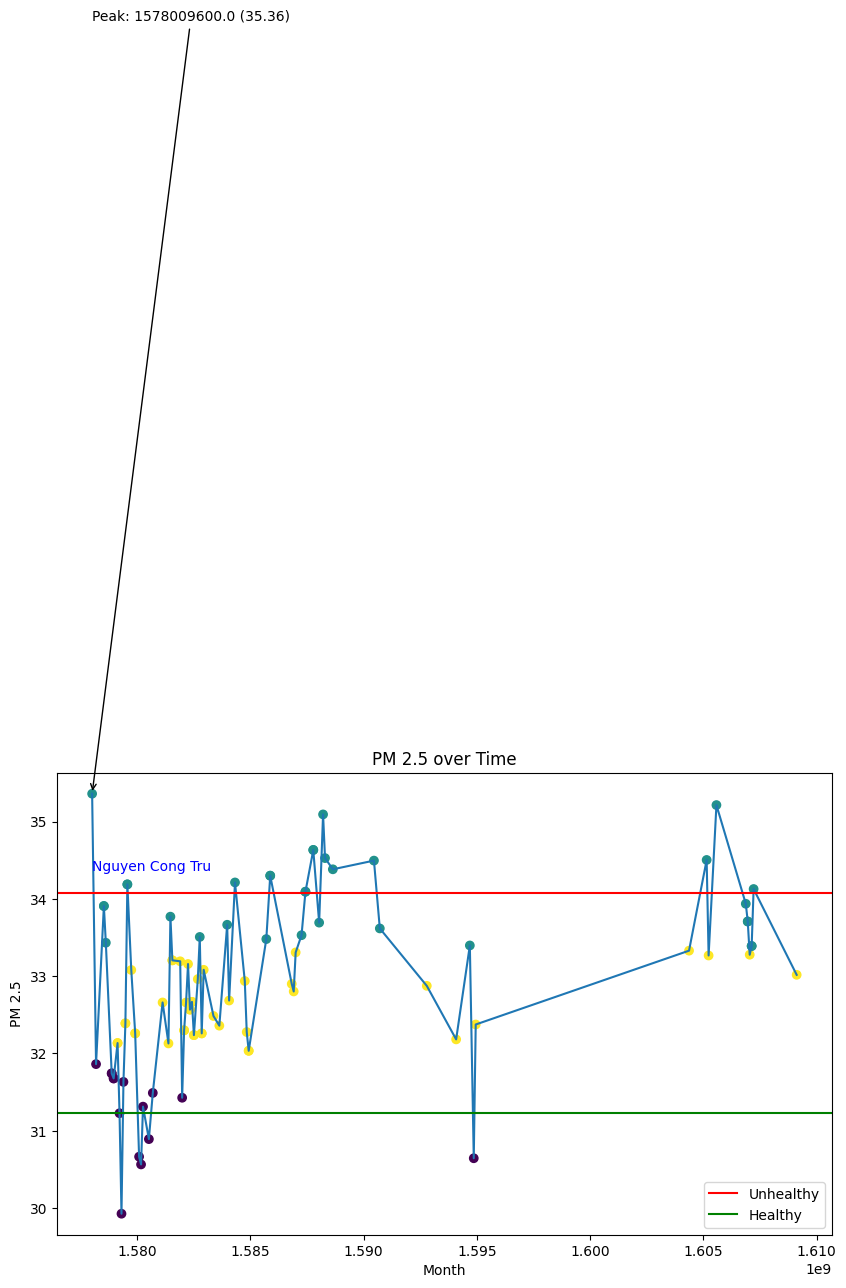

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


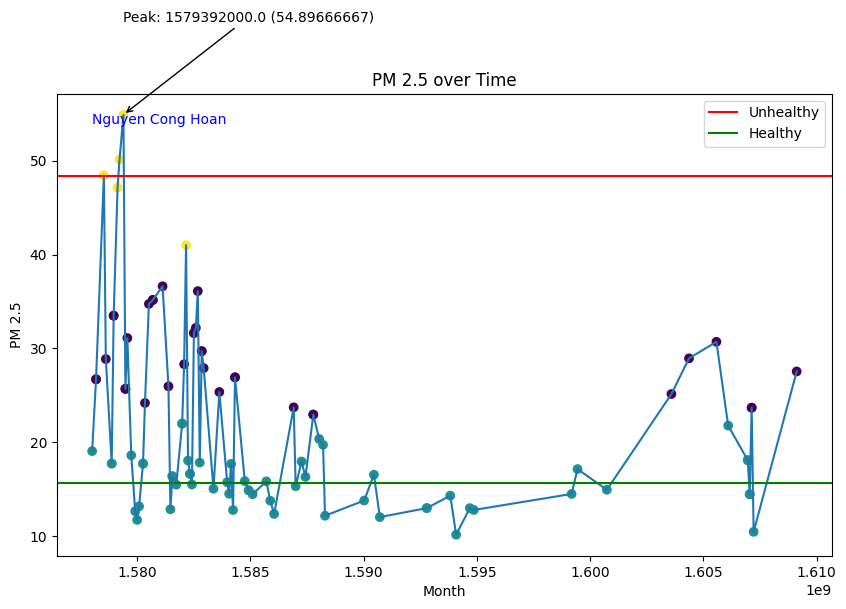

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


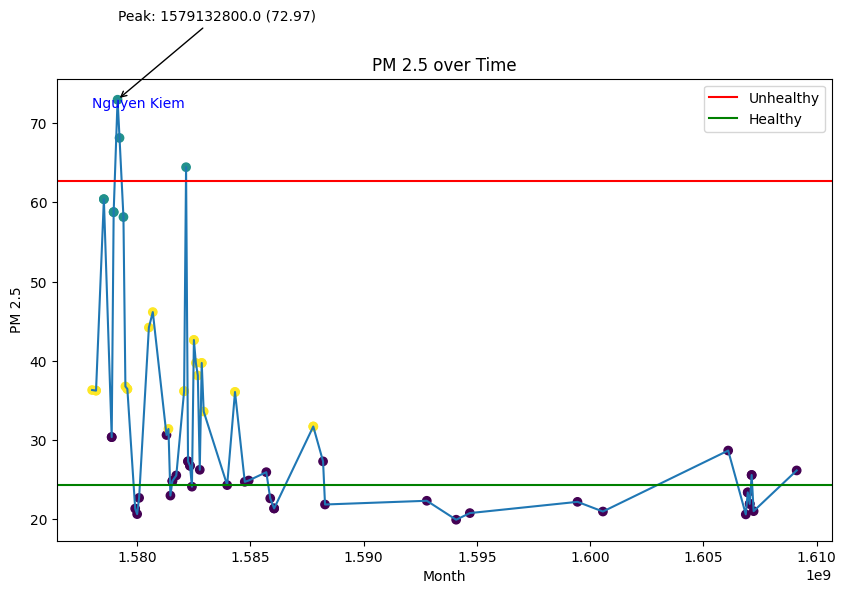

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


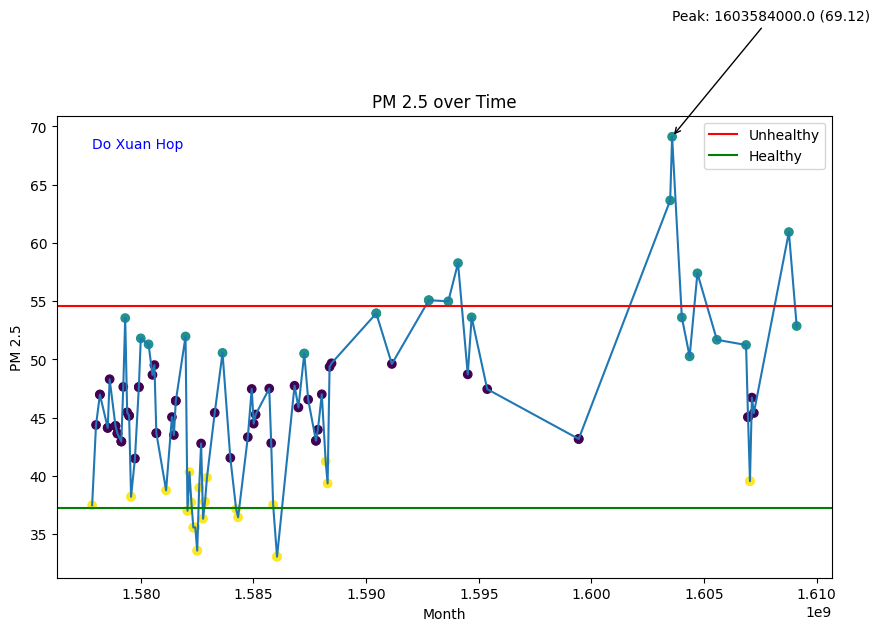

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


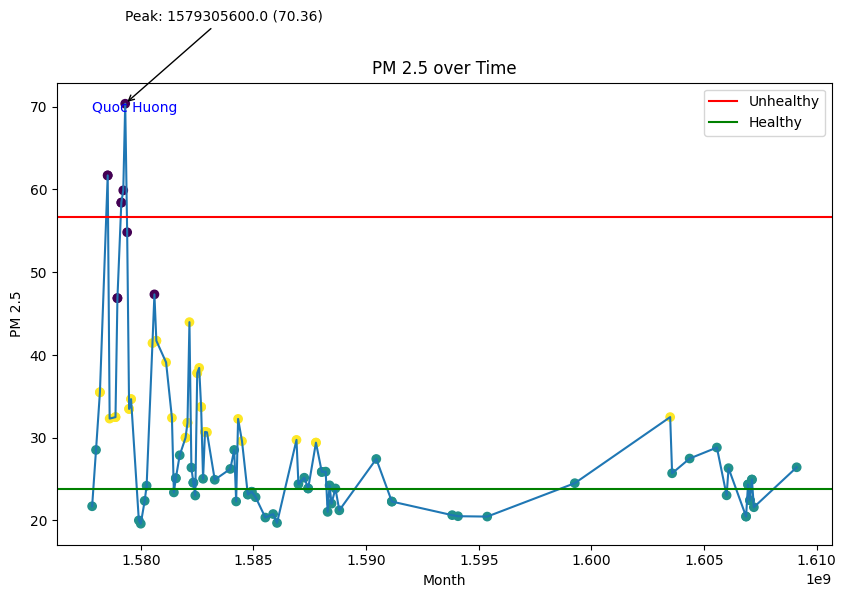

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


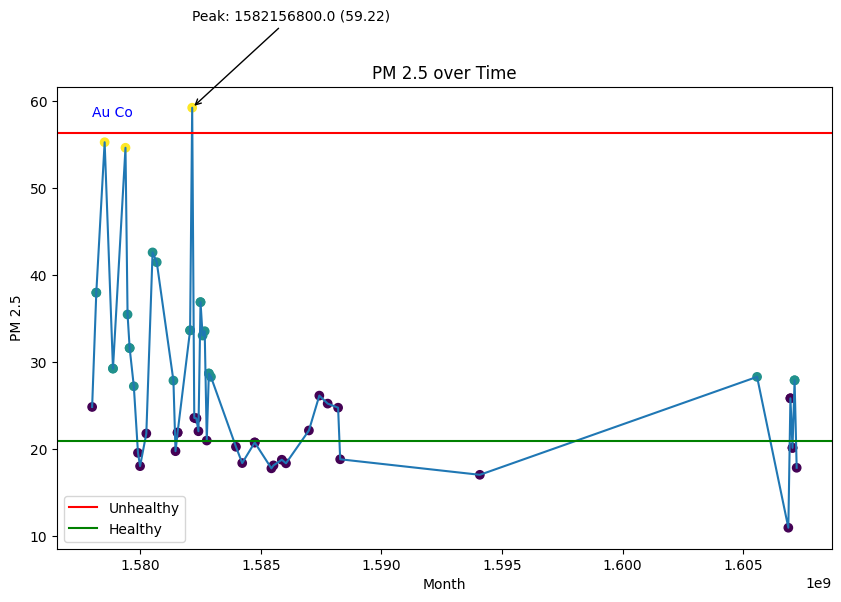

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


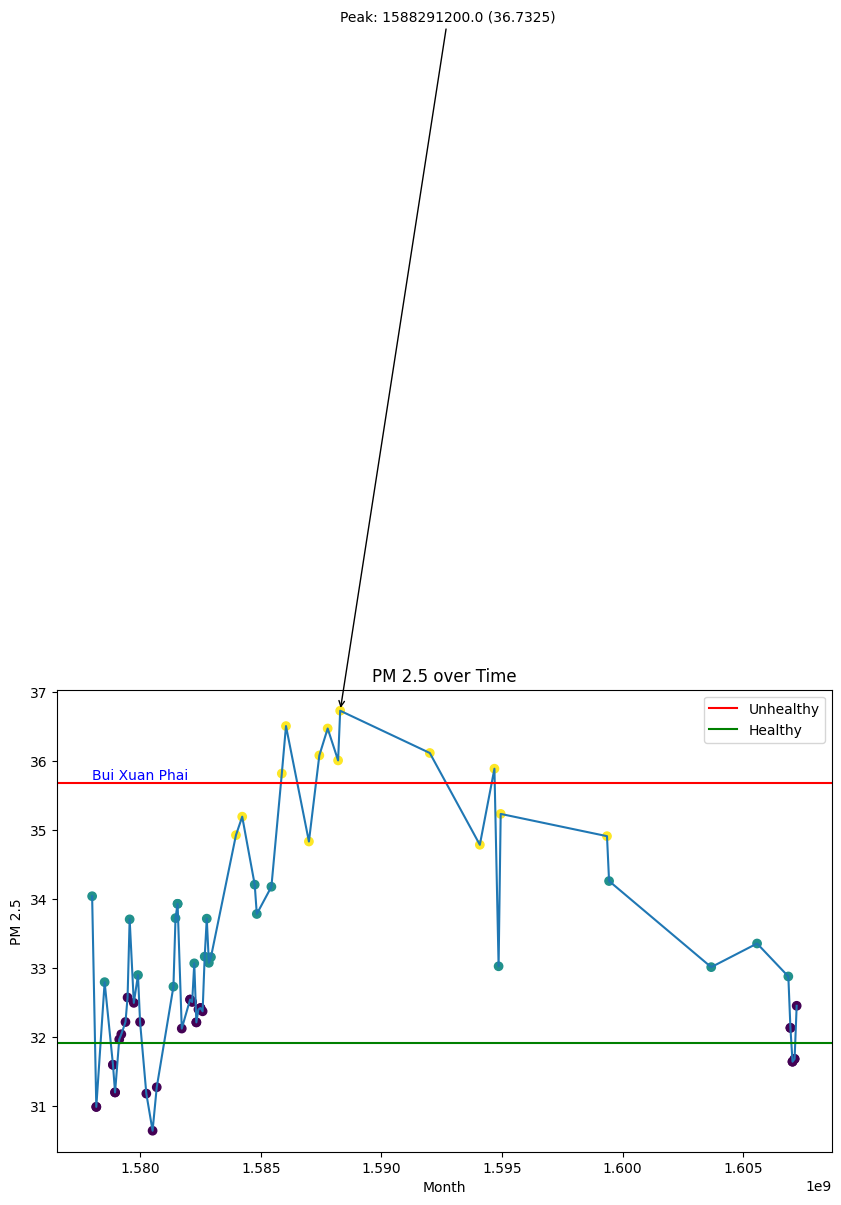

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


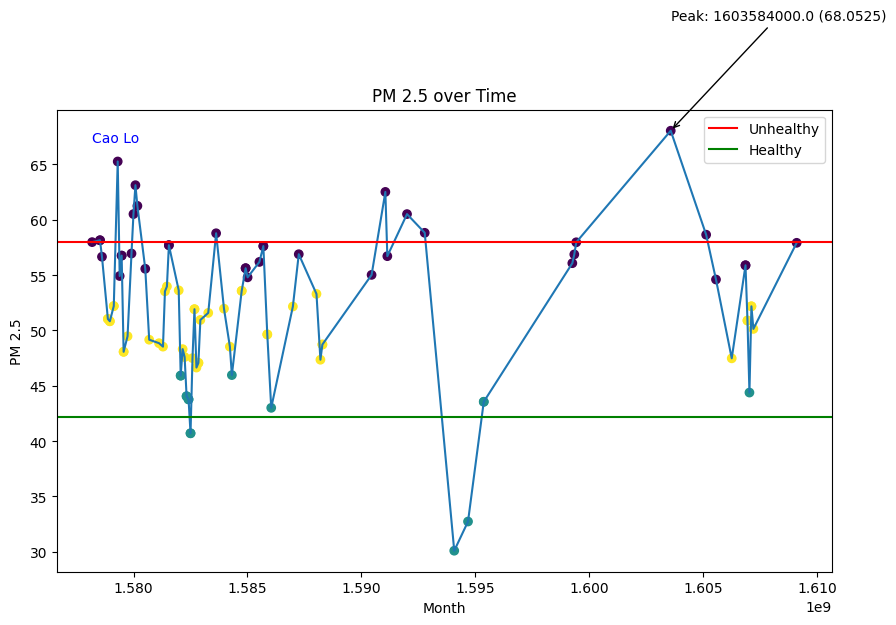

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


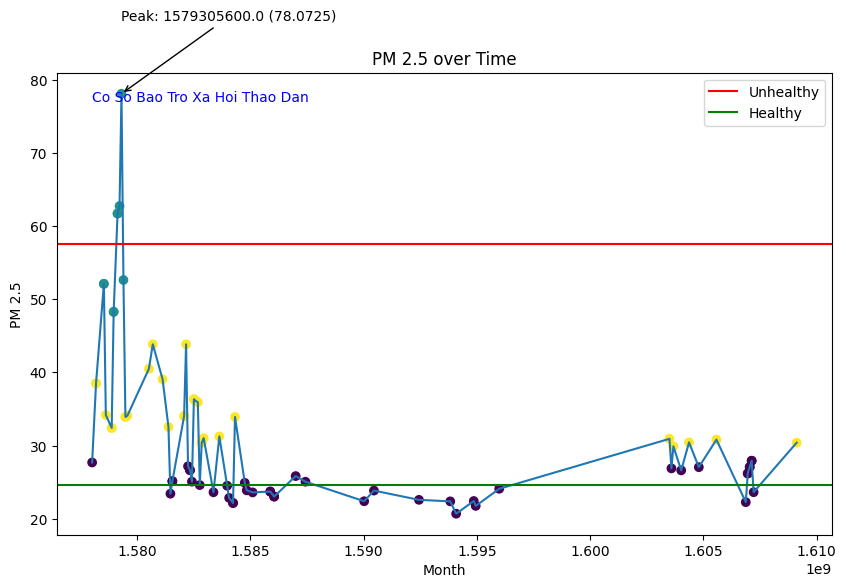

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


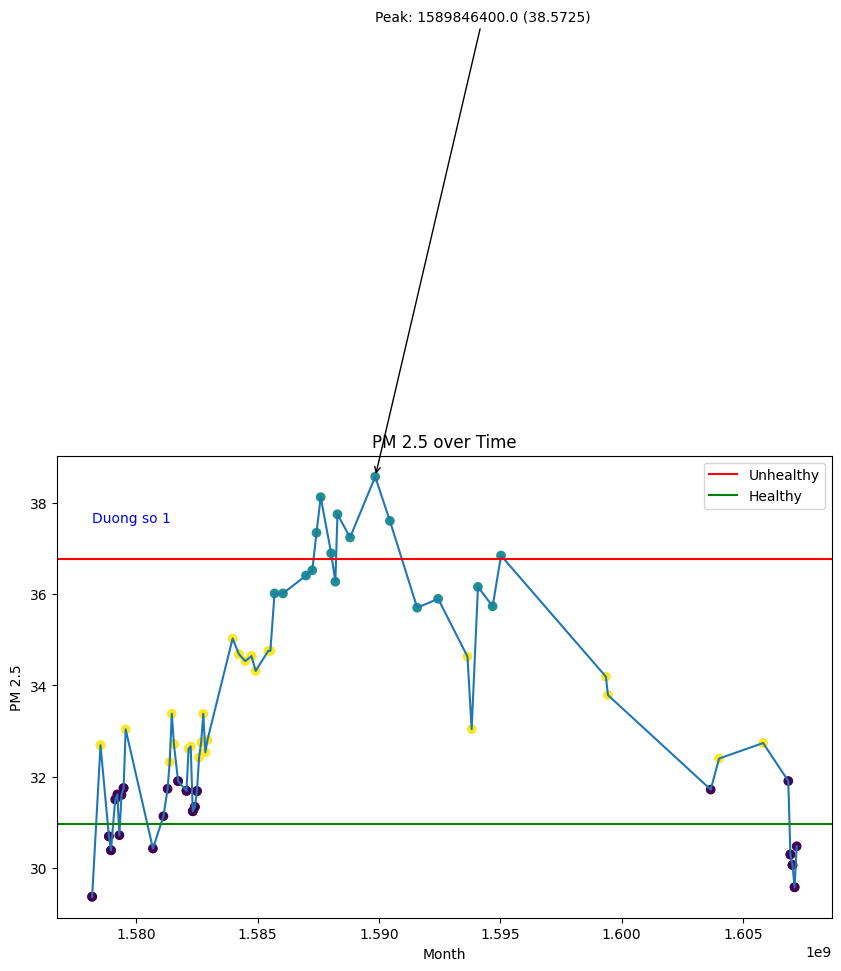

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


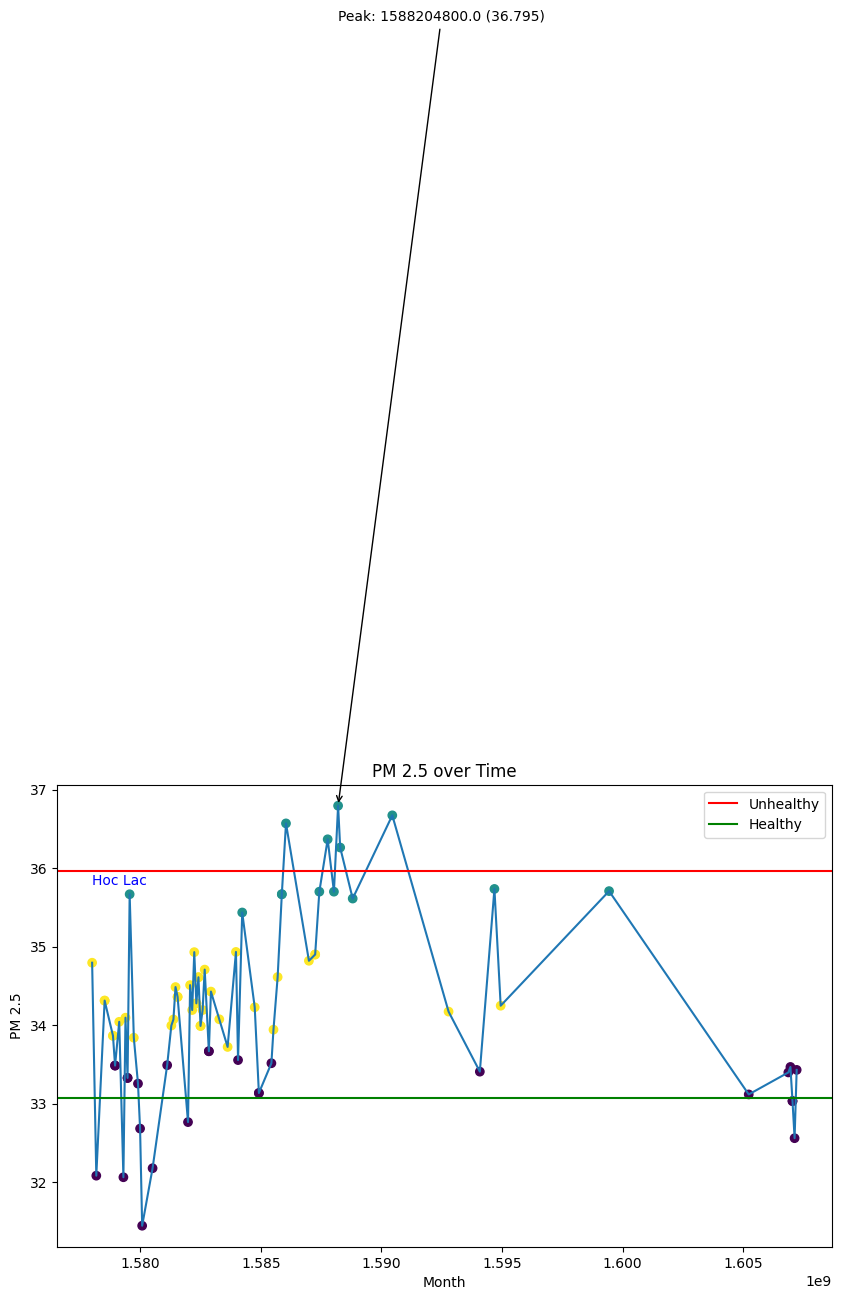

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


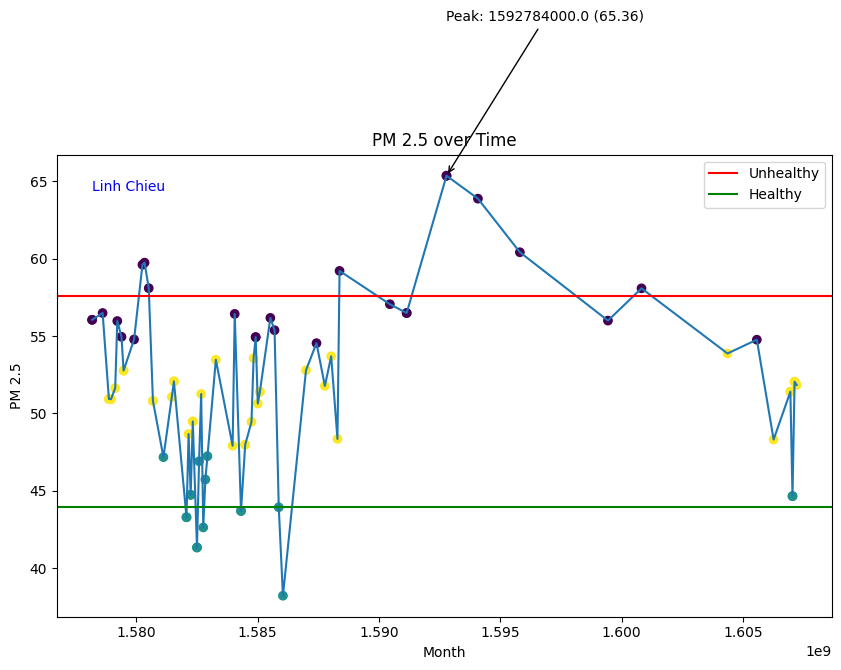

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


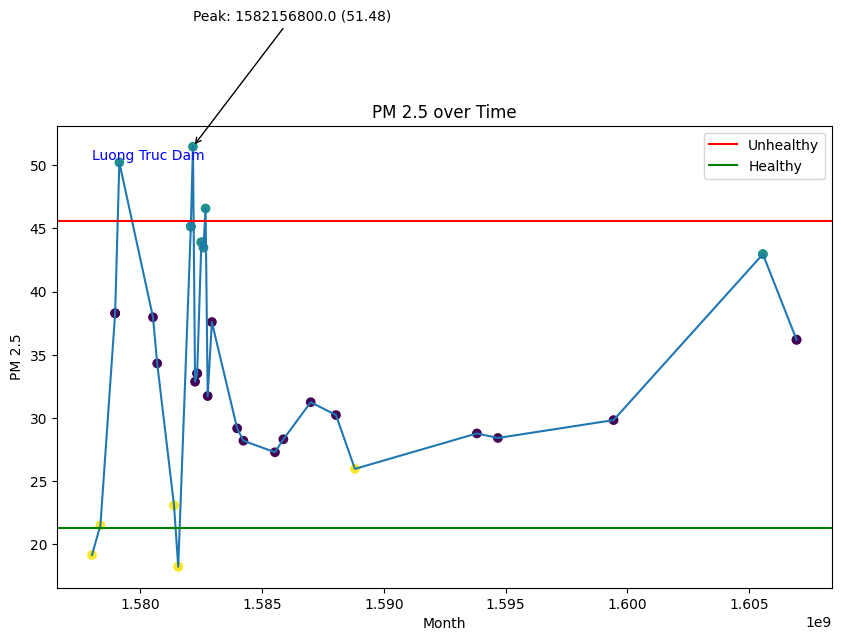

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


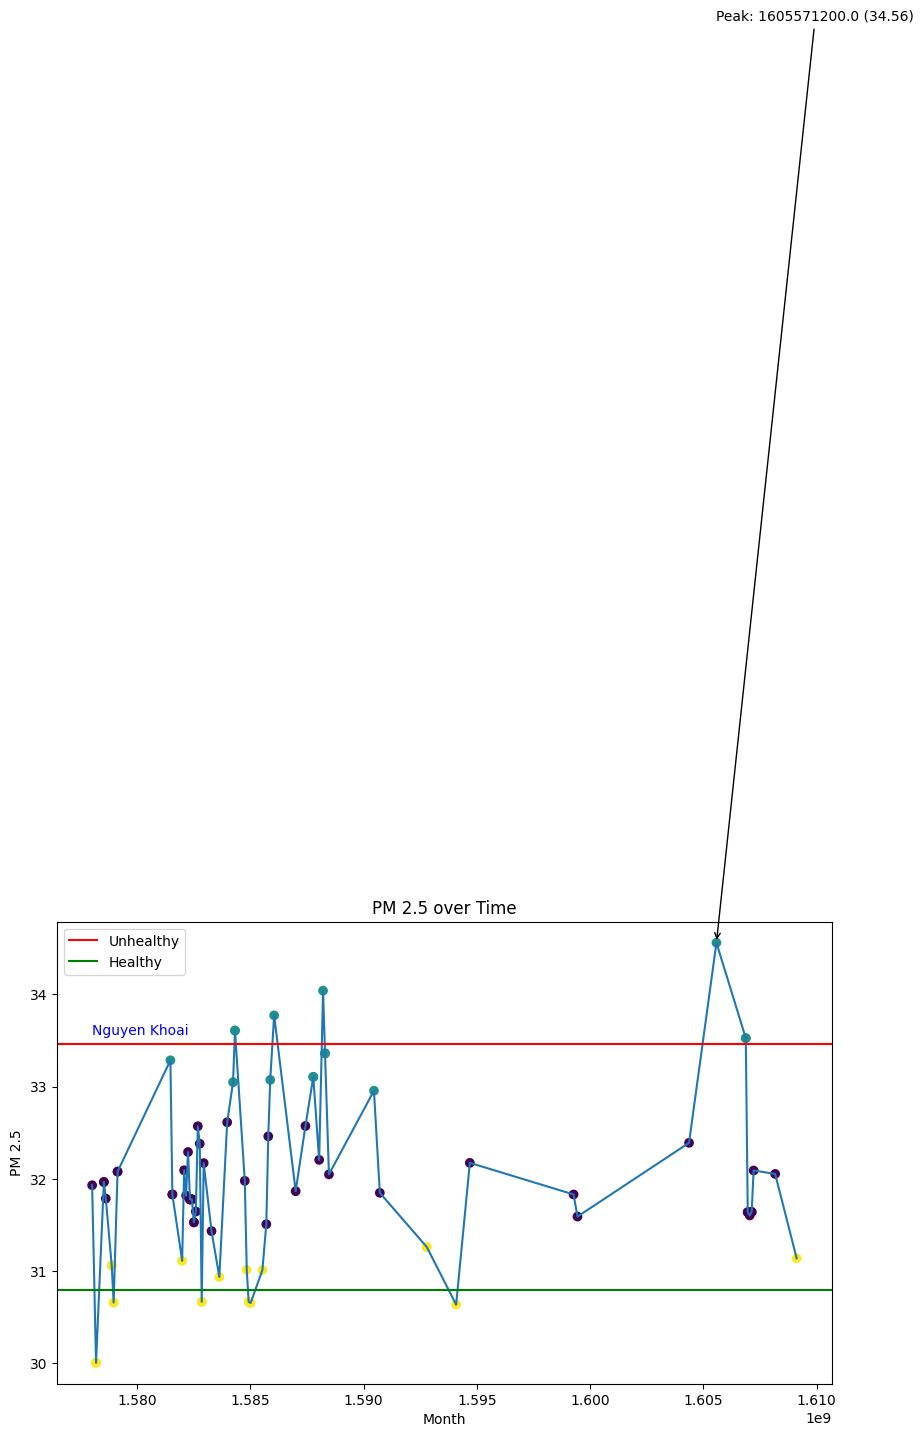

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


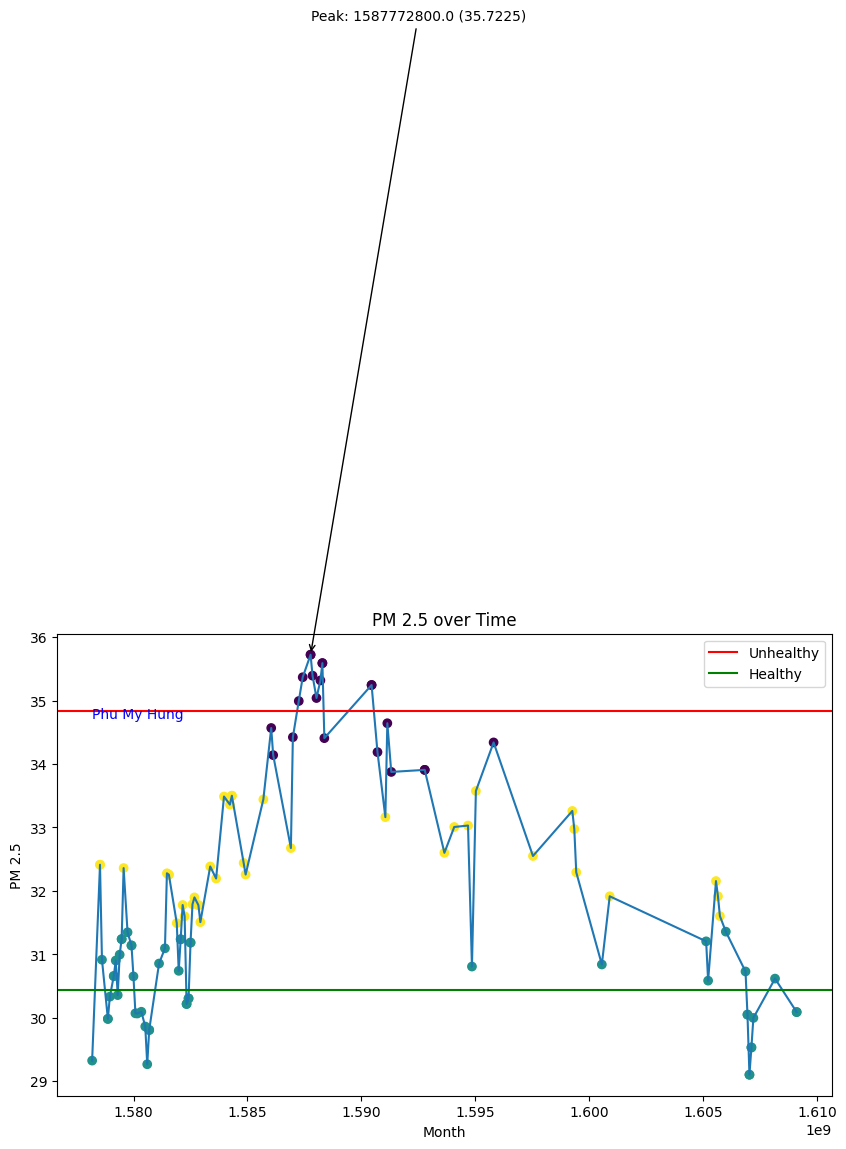

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


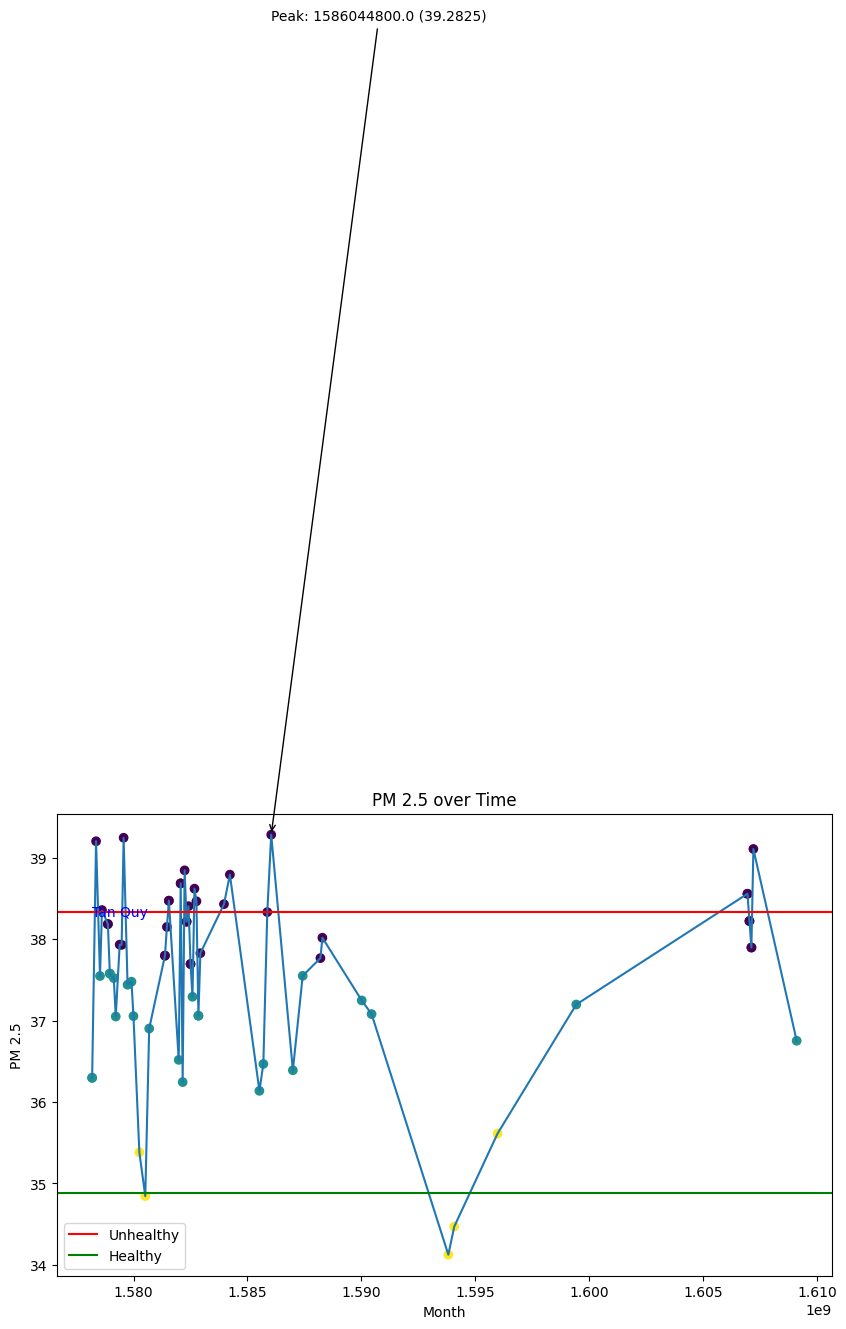

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


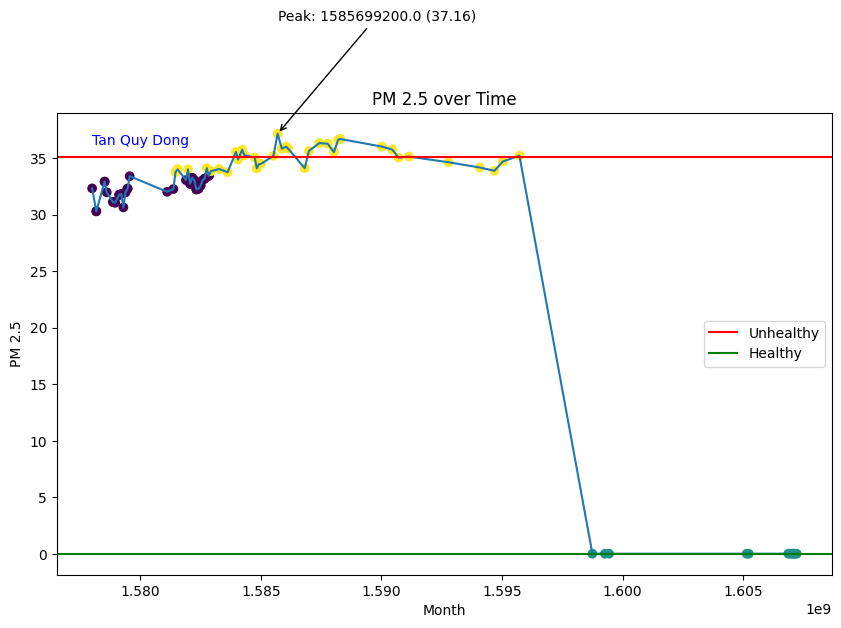

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


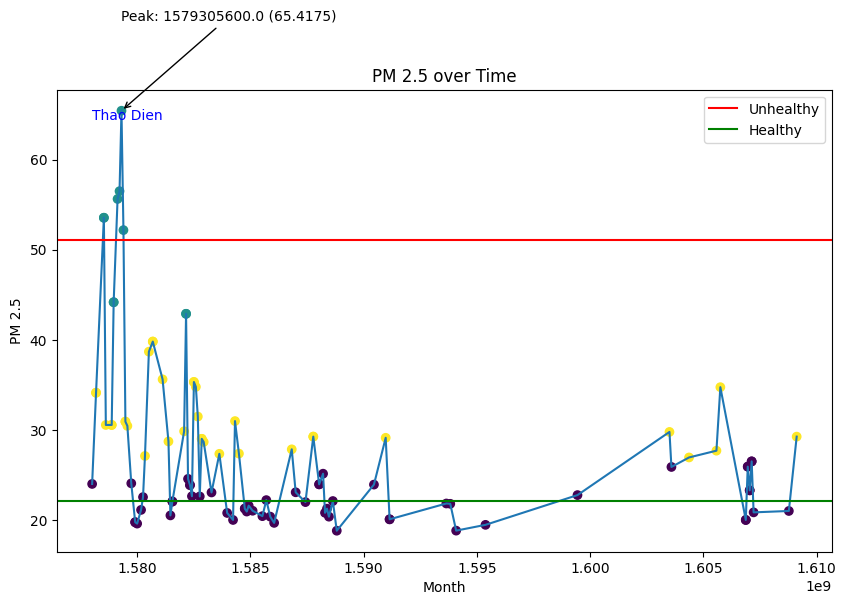

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


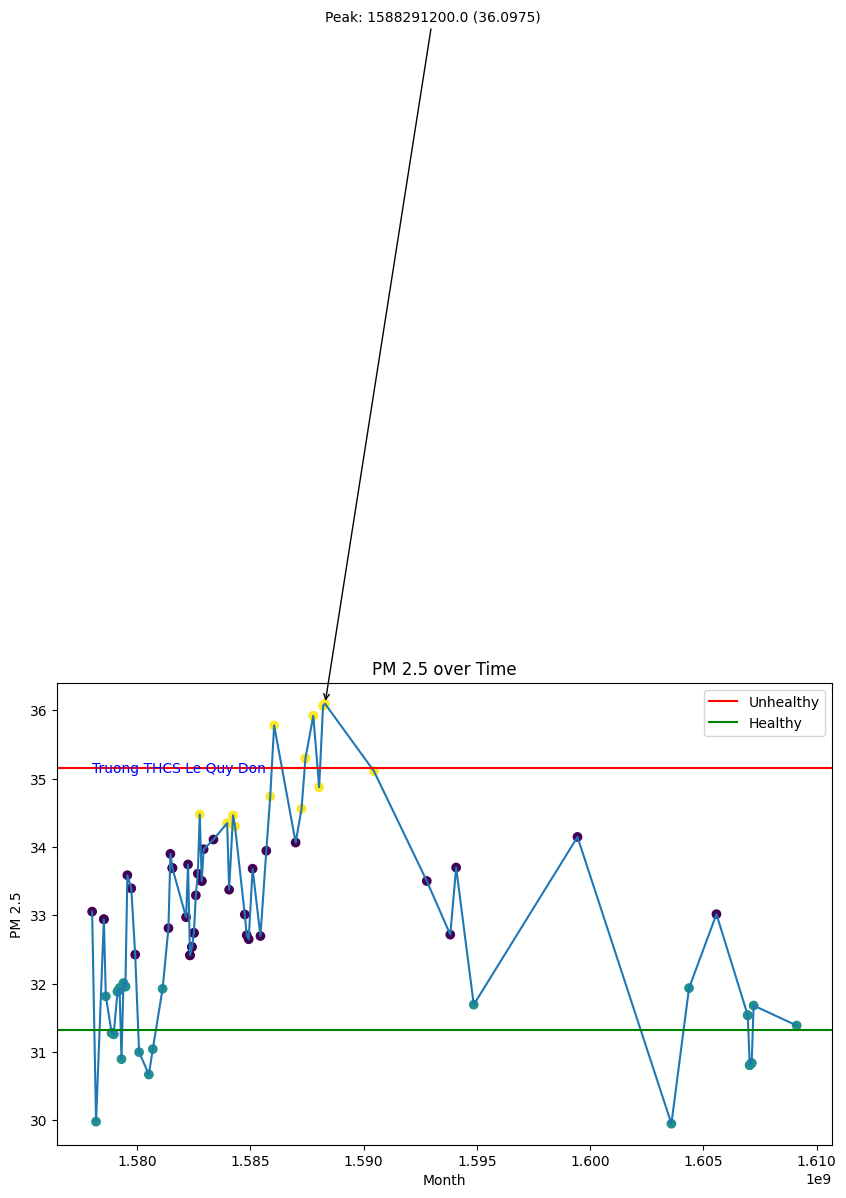

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


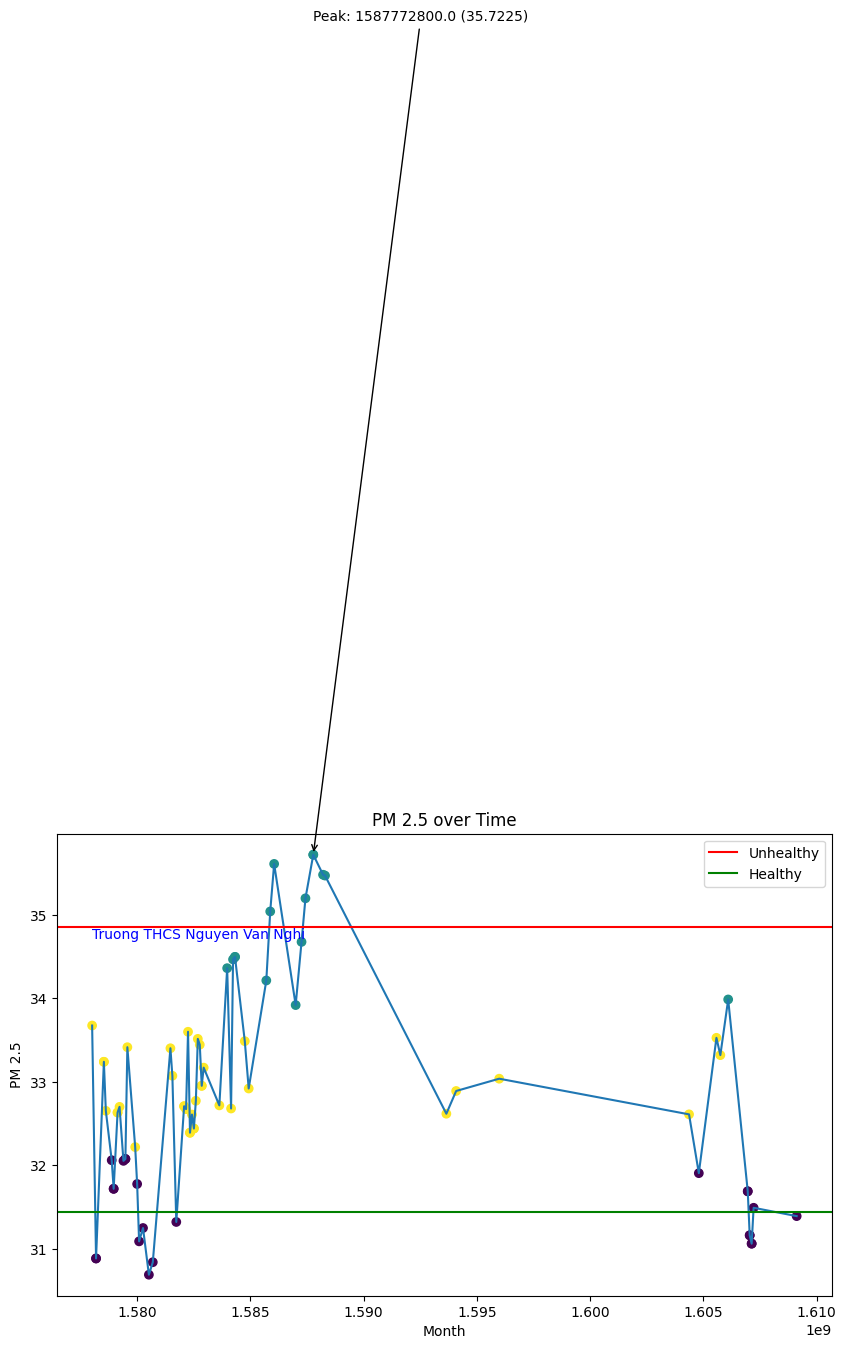

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


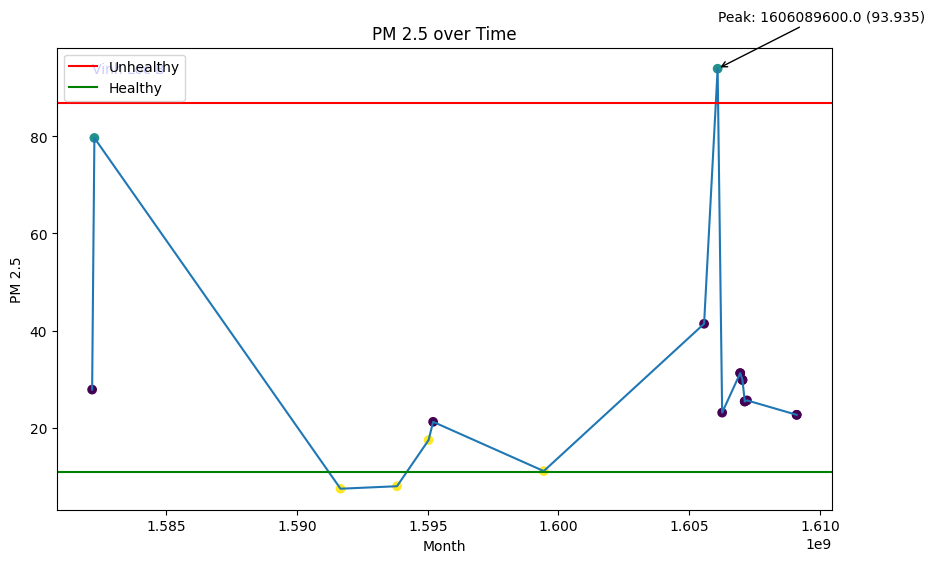

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


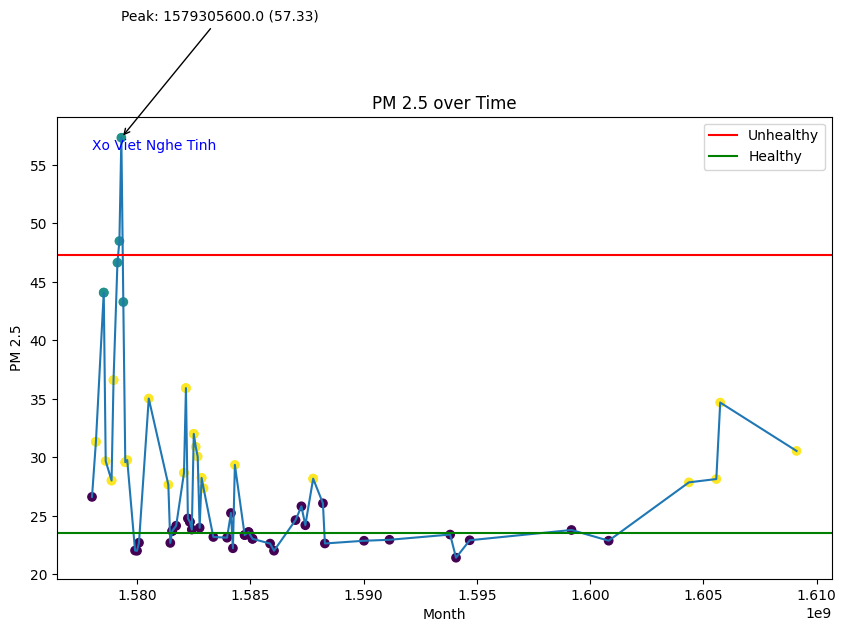

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

data_names = ["VNUHCM - 225 Nguyen Van Cu", "Tan Thuan Dong", "Tran Phu", "Nguyen Cong Tru", "Nguyen Cong Hoan", "Nguyen Kiem", "Do Xuan Hop", "Quoc Huong", "Au Co", "Bui Xuan Phai",
              "Cao Lo", "Co So Bao Tro Xa Hoi Thao Dan", "Duong so 1", "Hoc Lac", "Linh Chieu", "Luong Truc Dam", "Nguyen Khoai", "Phu My Hung", "Tan Quy",
              "Tan Quy Dong", "Thao Dien", "Truong THCS Le Quy Don", "Truong THCS Nguyen Van Nghi", "Vinh Loc B", "Xo Viet Nghe Tinh"]

for data, data_name in zip(data_list, data_names):
    # Select the date and PM2_5 columns
    result = data.select("date", "PM2_5")
    result = result.na.drop()

    # Collect the data to the driver node
    data_list1 = result.collect()

    # Extract date and PM2_5 values from the collected data
    dates = [row.date for row in data_list1]
    pm_values = [row.PM2_5 for row in data_list1]

    # Perform K-means clustering
    X = np.array(pm_values).reshape(-1, 1)
    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(X)

    # Calculate the cluster centers
    cluster_centers = kmeans.cluster_centers_

    # Determine the healthy and unhealthy thresholds
    unhealthy_threshold = np.max(cluster_centers)
    healthy_threshold = np.min(cluster_centers)

    # Plot the data and PM2.5 with K-means labels
    plt.figure(figsize=(10, 6))
    plt.plot(dates, pm_values)
    plt.scatter(dates, pm_values, c=labels, cmap='viridis')
    plt.xlabel('Month')
    plt.ylabel('PM 2.5')
    plt.title('PM 2.5 over Time')

    # Annotate the peak on the plot
    if pm_values:
        peak_index = np.argmax(pm_values)
        peak_date = dates[peak_index]
        peak_pm = pm_values[peak_index]
        plt.annotate(f'Peak: {peak_date} ({peak_pm})', xy=(peak_date, peak_pm), xytext=(peak_date, peak_pm + 10),
                     arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Draw horizontal lines for unhealthy and healthy thresholds
    plt.axhline(y=unhealthy_threshold, color='r', linestyle='-', label="Unhealthy")
    plt.axhline(y=healthy_threshold, color='g', linestyle='-', label="Healthy")

    # Add data name and legend
    plt.text(dates[0], max(pm_values) - 1, data_name, color='blue')
    plt.legend()
    plt.show()